<a href="https://colab.research.google.com/github/Shirley31415926/API_heatwave/blob/main/07A_Topic_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install bertopic[all] -q
!pip install sentence-transformers -q

In [ ]:
# BERTopic input
!pip install bertopic
!pip install plotly
!pip install umap-learn

# 2023 Topic modelling

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-04-29 20:04:11,508 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/62 [00:00<?, ?it/s]

2025-04-29 20:05:08,209 - BERTopic - Embedding - Completed ✓
2025-04-29 20:05:08,211 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-29 20:05:15,845 - BERTopic - Dimensionality - Completed ✓
2025-04-29 20:05:15,850 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-29 20:05:22,519 - BERTopic - Cluster - Completed ✓
2025-04-29 20:05:22,526 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-29 20:05:22,953 - BERTopic - Representation - Completed ✓
2025-04-29 20:05:23,580 - BERTopic - Topic reduction - Reducing number of topics
2025-04-29 20:05:23,596 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-29 20:05:23,858 - BERTopic - Representation - Completed ✓
2025-04-29 20:05:23,863 - BERTopic - Topic reduction - Reduced number of topics from 232 to 50


Topic summaries:
   0 → heatwave_im
   1 → climate_change
   2 → ac_energy
   3 → help_people
   4 → cat_cats
   5 → plants_flowers
   6 → italy_greece
   7 → ice cream_cream
   8 → guilty beastly_beastly
   9 → print_rotten
  10 → arizona_phoenix
  11 → pool_office hours
  12 → water_bottle
  13 → wildlife_water
  14 → california_weather
  15 → dresses_wear
  16 → nxt_wrestling
  17 → spring_australia
  18 → chapter_cosplay
  19 → bottom row_rid
  20 → fire_bg
  21 → mail_package
  22 → texas_abbott
  23 → blinds_blackout
  24 → banfossilfuels_banfossilfuels carbon
  25 → border_migrants
  26 → smell_manure smell
  27 → prompt_gingerrose
  28 → trees_without permit
  29 → jamboree_scout
  30 → brazil_af fucked
  31 → latest_gothic
  32 → bike_musk
  33 → soup_beat made
  34 → quailsteed_linda rest
  35 → universal_trees
  36 → contrasts granite_boulder light
  37 → hospital_jazz
  38 → started_analog
  39 → christmas_chocolates
  40 → hat_crocheting smol
  41 → getting today_better we

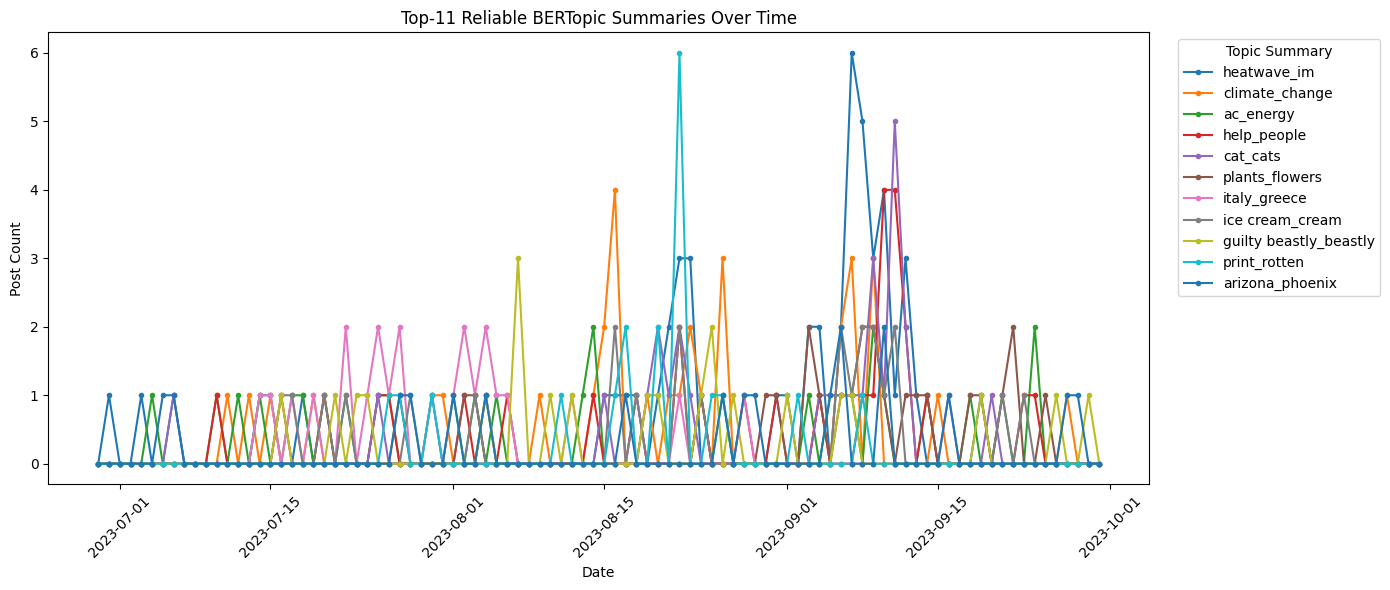

94it [00:06, 13.61it/s]


In [ ]:
!pip install bertopic umap-learn plotly nltk sentence-transformers -q

import re
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
import plotly.io as pio

pio.renderers.default = "colab"
nltk.download("stopwords")
STOP_WORDS = stopwords.words("english")

DATA_PATH = "/content/drive/MyDrive/heat_posts2023.jsonl"
posts_df = pd.read_json(DATA_PATH, lines=True)

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r"www\.\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text

posts_df["clean_text"] = posts_df["text"].apply(clean_text)
posts_df["date"] = pd.to_datetime(posts_df["created_at"]).dt.date

texts = posts_df["clean_text"].tolist()
dates = posts_df["date"].tolist()

### train BERTopic
topic_model = BERTopic(
    embedding_model=SentenceTransformer("all-MiniLM-L6-v2"),
    vectorizer_model=CountVectorizer(stop_words=STOP_WORDS, ngram_range=(1,2)),
    language="english",
    calculate_probabilities=True,
    verbose=True,
    min_topic_size=2,
)

topics, probs = topic_model.fit_transform(texts)
posts_df["topic"] = topics


topic_model.reduce_topics(texts, nr_topics=50)

### topic abstract
summary_map = {}
for t in topic_model.get_topic_info().Topic:
    if t == -1:
        continue
    top2 = [w for w,_ in topic_model.get_topic(t)[:2]]
    summary_map[t] = "_".join(top2)

posts_df["topic_summary"] = posts_df["topic"].map(lambda t: summary_map.get(t, "Other"))

print("Topic summaries:")
for t, label in summary_map.items():
    print(f"  {t:2d} → {label}")


label_dict = {
    "Health":  ["heatstroke","hospital","dehydration","emergency","risk","dizzy","overheat"],
    "Energy":  ["power","outage","electricity","grid","air conditioning","cooling","blackout"],
    "Policy":  ["government","response","support","aid","fund","relief","governor"],
    "Climate": ["climate","crisis","warming","carbon","emission","anxiety"]
}

def assign_label(keywords, mapping):
    keys = set(w for w,_ in keywords)
    scores = {lbl: len(keys & set(words)) for lbl,words in mapping.items()}
    return max(scores, key=scores.get) if max(scores.values())>0 else "Other"

topic_label_map = {
    t: assign_label(topic_model.get_topic(t), label_dict)
    for t in summary_map.keys()
}
posts_df["semantic_label"] = posts_df["topic"].map(lambda t: topic_label_map.get(t, "Other"))

### 11 reliable topics
top_topics_df = topic_model.get_topic_info()
top_topics_df = top_topics_df[top_topics_df.Topic != -1]
top11_topic_ids = top_topics_df.head(11).Topic.tolist()
top11_summaries = [summary_map[t] for t in top11_topic_ids]

time_df = posts_df.groupby(["date","topic_summary"]).size().unstack(fill_value=0)
time_df = time_df[top11_summaries]

plt.figure(figsize=(14,6))
for lbl in top11_summaries:
    plt.plot(time_df.index, time_df[lbl], marker=".", label=lbl)

plt.title("Top-11 Reliable BERTopic Summaries Over Time")
plt.xlabel("Date")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.legend(title="Topic Summary", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

### save
posts_df.to_csv("heatwave_posts_with_topics.csv", index=False)
pd.DataFrame(topic_model.topics_over_time(texts, dates)).to_csv("topics_over_time.csv", index=False)


In [ ]:
topic_model.visualize_barchart(top_n_topics=11).show()

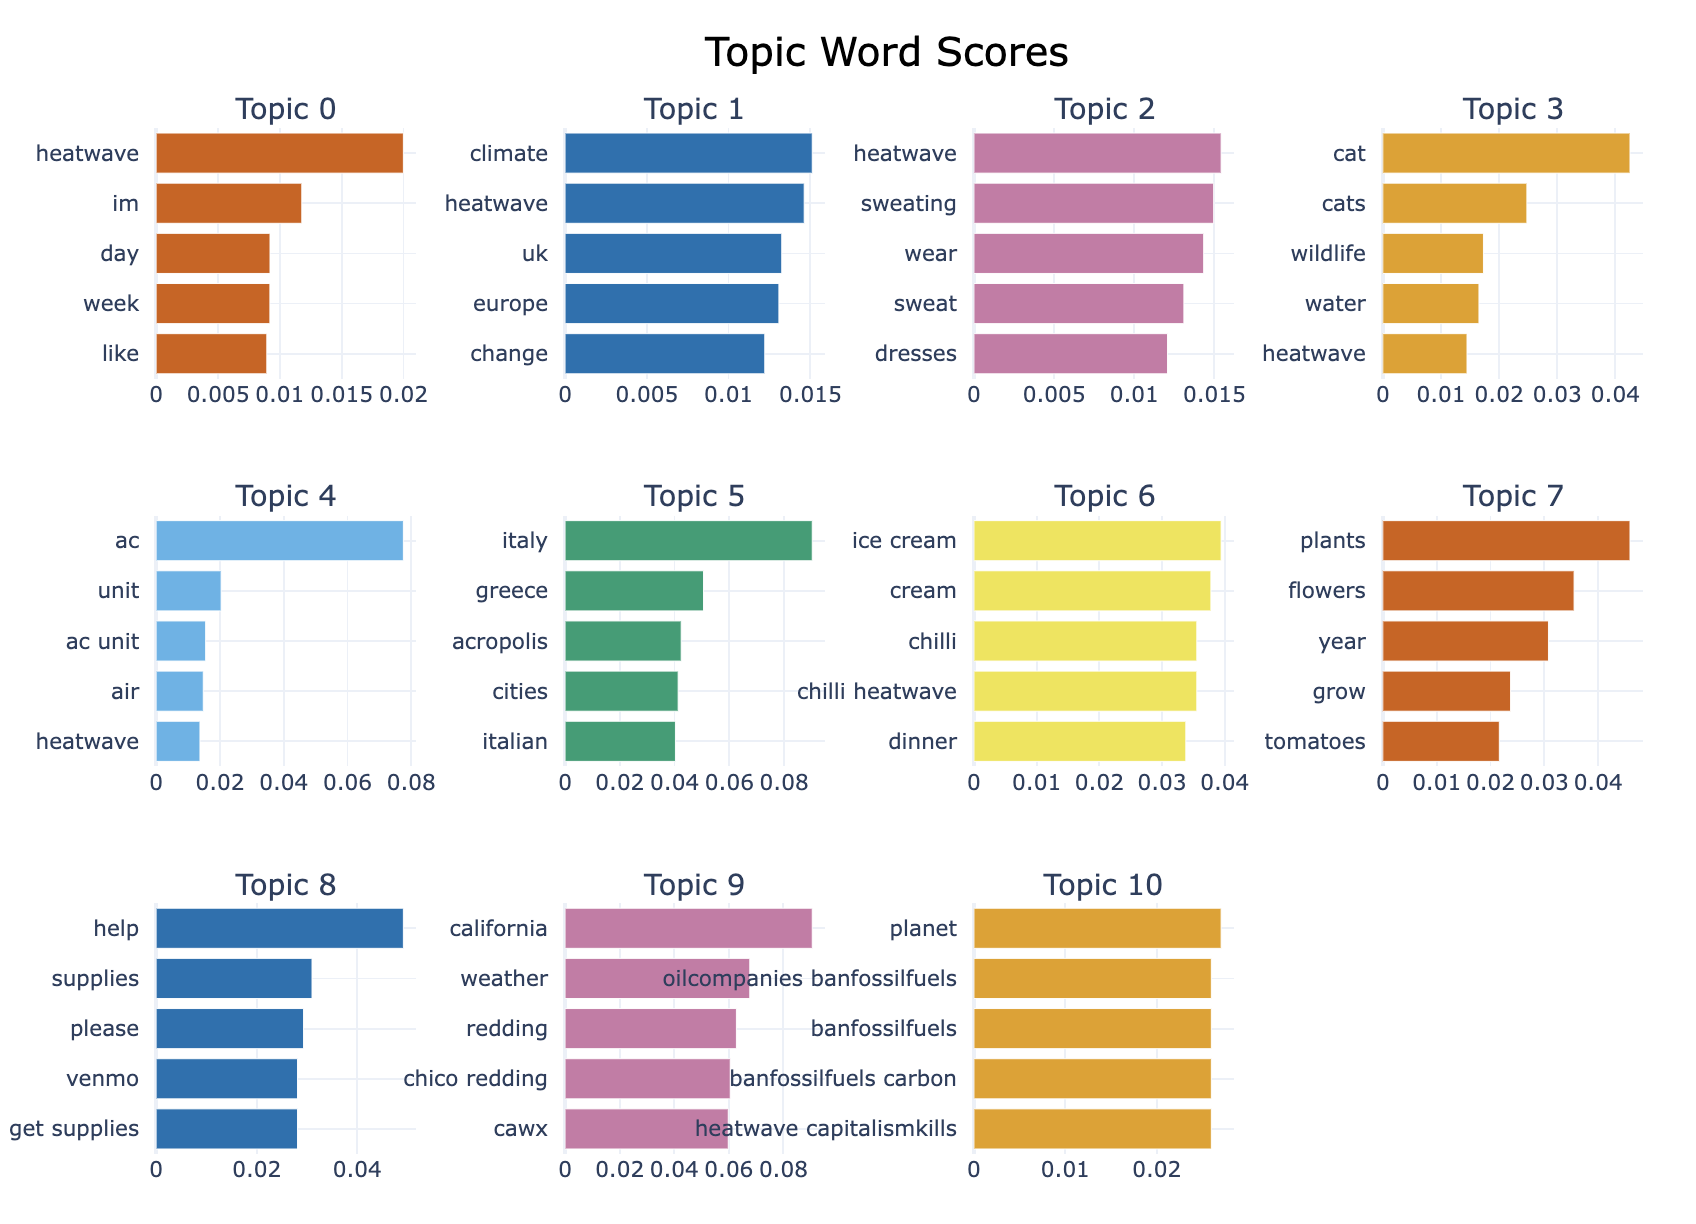

# 2024 Topic modelling

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2025-04-29 19:53:05,477 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/127 [00:00<?, ?it/s]

2025-04-29 19:54:49,688 - BERTopic - Embedding - Completed ✓
2025-04-29 19:54:49,690 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-29 19:55:18,588 - BERTopic - Dimensionality - Completed ✓
2025-04-29 19:55:18,589 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-29 19:56:36,787 - BERTopic - Cluster - Completed ✓
2025-04-29 19:56:36,795 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-29 19:56:38,169 - BERTopic - Representation - Completed ✓
2025-04-29 19:56:40,004 - BERTopic - Topic reduction - Reducing number of topics
2025-04-29 19:56:40,034 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-29 19:56:40,530 - BERTopic - Representation - Completed ✓
2025-04-29 19:56:40,535 - BERTopic - Topic reduction - Reduced number of topics from 469 to 50


Topic summaries:
   0 → heatwave_heat
   1 → art_heatwave
   2 → india_japan
   3 → water_cat
   4 → garden_flowers
   5 → coffee_tea
   6 → wearing_wear
   7 → august_saturday
   8 → brain_headache
   9 → greece_croatia
  10 → hydrated_stay hydrated
  11 → nxt_wrestling
  12 → bike_ride
  13 → writing_story
  14 → disabled_pls
  15 → broadcast june_broadcast
  16 → fire_fireworks
  17 → forecast_weather wx
  18 → genai_heatwave genai
  19 → livewire_superman
  20 → shes_mom
  21 → sale_ad
  22 → gouging_price
  23 → caleb graves_disneyland
  24 → las_las vegas
  25 → goals speak_goals
  26 → daily digest_digest
  27 → guy_etsy shop
  28 → neighbor_chin
  29 → captain_captain cold
  30 → earthquake_tornado
  31 → art taintedstarbskysocial_da fridge
  32 → rescue_bots
  33 → flat_outside
  34 → globalwarming_drought
  35 → summer_etc
  36 → big oil_homicide
  37 → wax_melting heatwave
  38 → meds_interfere
  39 → meteorologist_accuweather
  40 → heatwave duration_duration
  41 → ai_gran

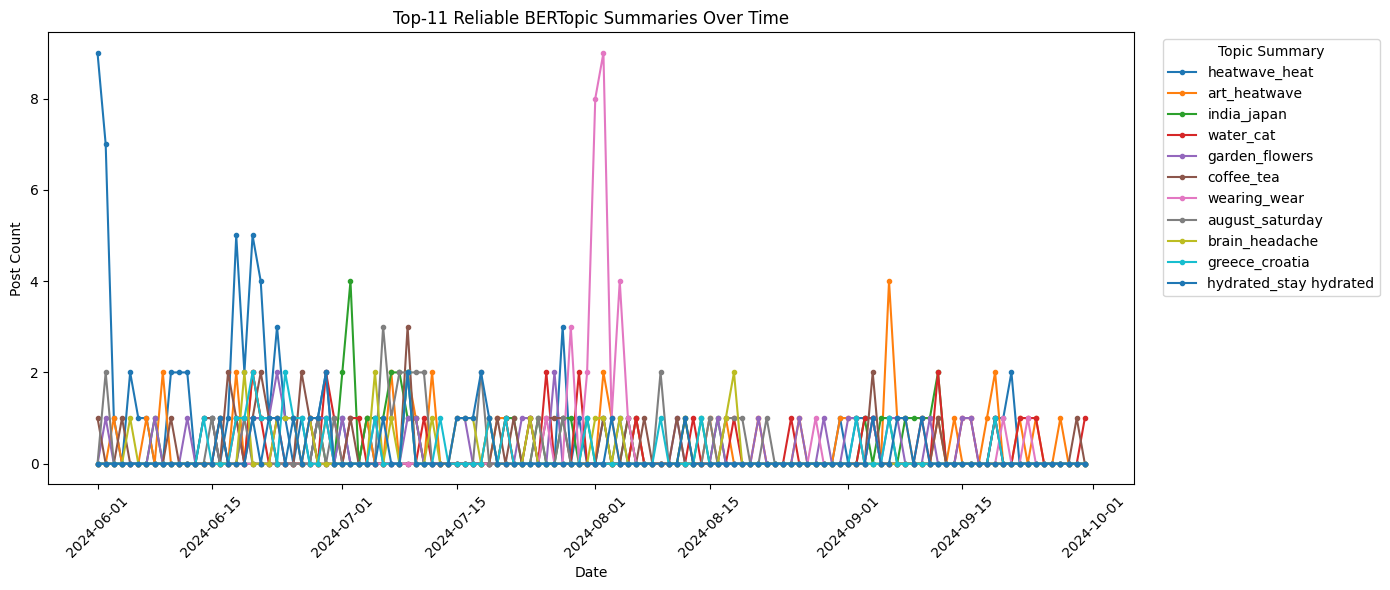

2025-04-29 19:56:41,486 - BERTopic - WARNING: There are more than 100 unique timestamps (i.e., 122) which significantly slows down the application. Consider setting `nr_bins` to a value lower than 100 to speed up calculation. 
122it [00:19,  6.30it/s]


In [ ]:
!pip install bertopic umap-learn plotly nltk sentence-transformers -q

import re
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
import plotly.io as pio

pio.renderers.default = "colab"
nltk.download("stopwords")
STOP_WORDS = stopwords.words("english")

DATA_PATH = "/content/drive/MyDrive/heat_posts2024_standardized.jsonl"
posts_df = pd.read_json(DATA_PATH, lines=True)

def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r"www\.\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text

posts_df["clean_text"] = posts_df["text"].apply(clean_text)
posts_df["date"] = pd.to_datetime(posts_df["created_at"]).dt.date

texts = posts_df["clean_text"].tolist()
dates = posts_df["date"].tolist()

topic_model = BERTopic(
    embedding_model=SentenceTransformer("all-MiniLM-L6-v2"),
    vectorizer_model=CountVectorizer(stop_words=STOP_WORDS, ngram_range=(1,2)),
    language="english",
    calculate_probabilities=True,
    verbose=True,
    min_topic_size=2,
)

topics, probs = topic_model.fit_transform(texts)
posts_df["topic"] = topics

topic_model.reduce_topics(texts, nr_topics=50)

summary_map = {}
for t in topic_model.get_topic_info().Topic:
    if t == -1:
        continue
    top2 = [w for w,_ in topic_model.get_topic(t)[:2]]
    summary_map[t] = "_".join(top2)

posts_df["topic_summary"] = posts_df["topic"].map(lambda t: summary_map.get(t, "Other"))

print("Topic summaries:")
for t, label in summary_map.items():
    print(f"  {t:2d} → {label}")

label_dict = {
    "Health":  ["heatstroke","hospital","dehydration","emergency","risk","dizzy","overheat"],
    "Energy":  ["power","outage","electricity","grid","air conditioning","cooling","blackout"],
    "Policy":  ["government","response","support","aid","fund","relief","governor"],
    "Climate": ["climate","crisis","warming","carbon","emission","anxiety"]
}

def assign_label(keywords, mapping):
    keys = set(w for w,_ in keywords)
    scores = {lbl: len(keys & set(words)) for lbl,words in mapping.items()}
    return max(scores, key=scores.get) if max(scores.values())>0 else "Other"

topic_label_map = {
    t: assign_label(topic_model.get_topic(t), label_dict)
    for t in summary_map.keys()
}
posts_df["semantic_label"] = posts_df["topic"].map(lambda t: topic_label_map.get(t, "Other"))

top_topics_df = topic_model.get_topic_info()
top_topics_df = top_topics_df[top_topics_df.Topic != -1]
top11_topic_ids = top_topics_df.head(11).Topic.tolist()
top11_summaries = [summary_map[t] for t in top11_topic_ids]

time_df = posts_df.groupby(["date","topic_summary"]).size().unstack(fill_value=0)
time_df = time_df[top11_summaries]

plt.figure(figsize=(14,6))
for lbl in top11_summaries:
    plt.plot(time_df.index, time_df[lbl], marker=".", label=lbl)

plt.title("Top-11 Reliable BERTopic Summaries Over Time")
plt.xlabel("Date")
plt.ylabel("Post Count")
plt.xticks(rotation=45)
plt.legend(title="Topic Summary", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()

posts_df.to_csv("heatwave_posts_with_topics.csv", index=False)
pd.DataFrame(topic_model.topics_over_time(texts, dates)).to_csv("topics_over_time.csv", index=False)

In [ ]:
topic_model.visualize_barchart(top_n_topics=11).show()

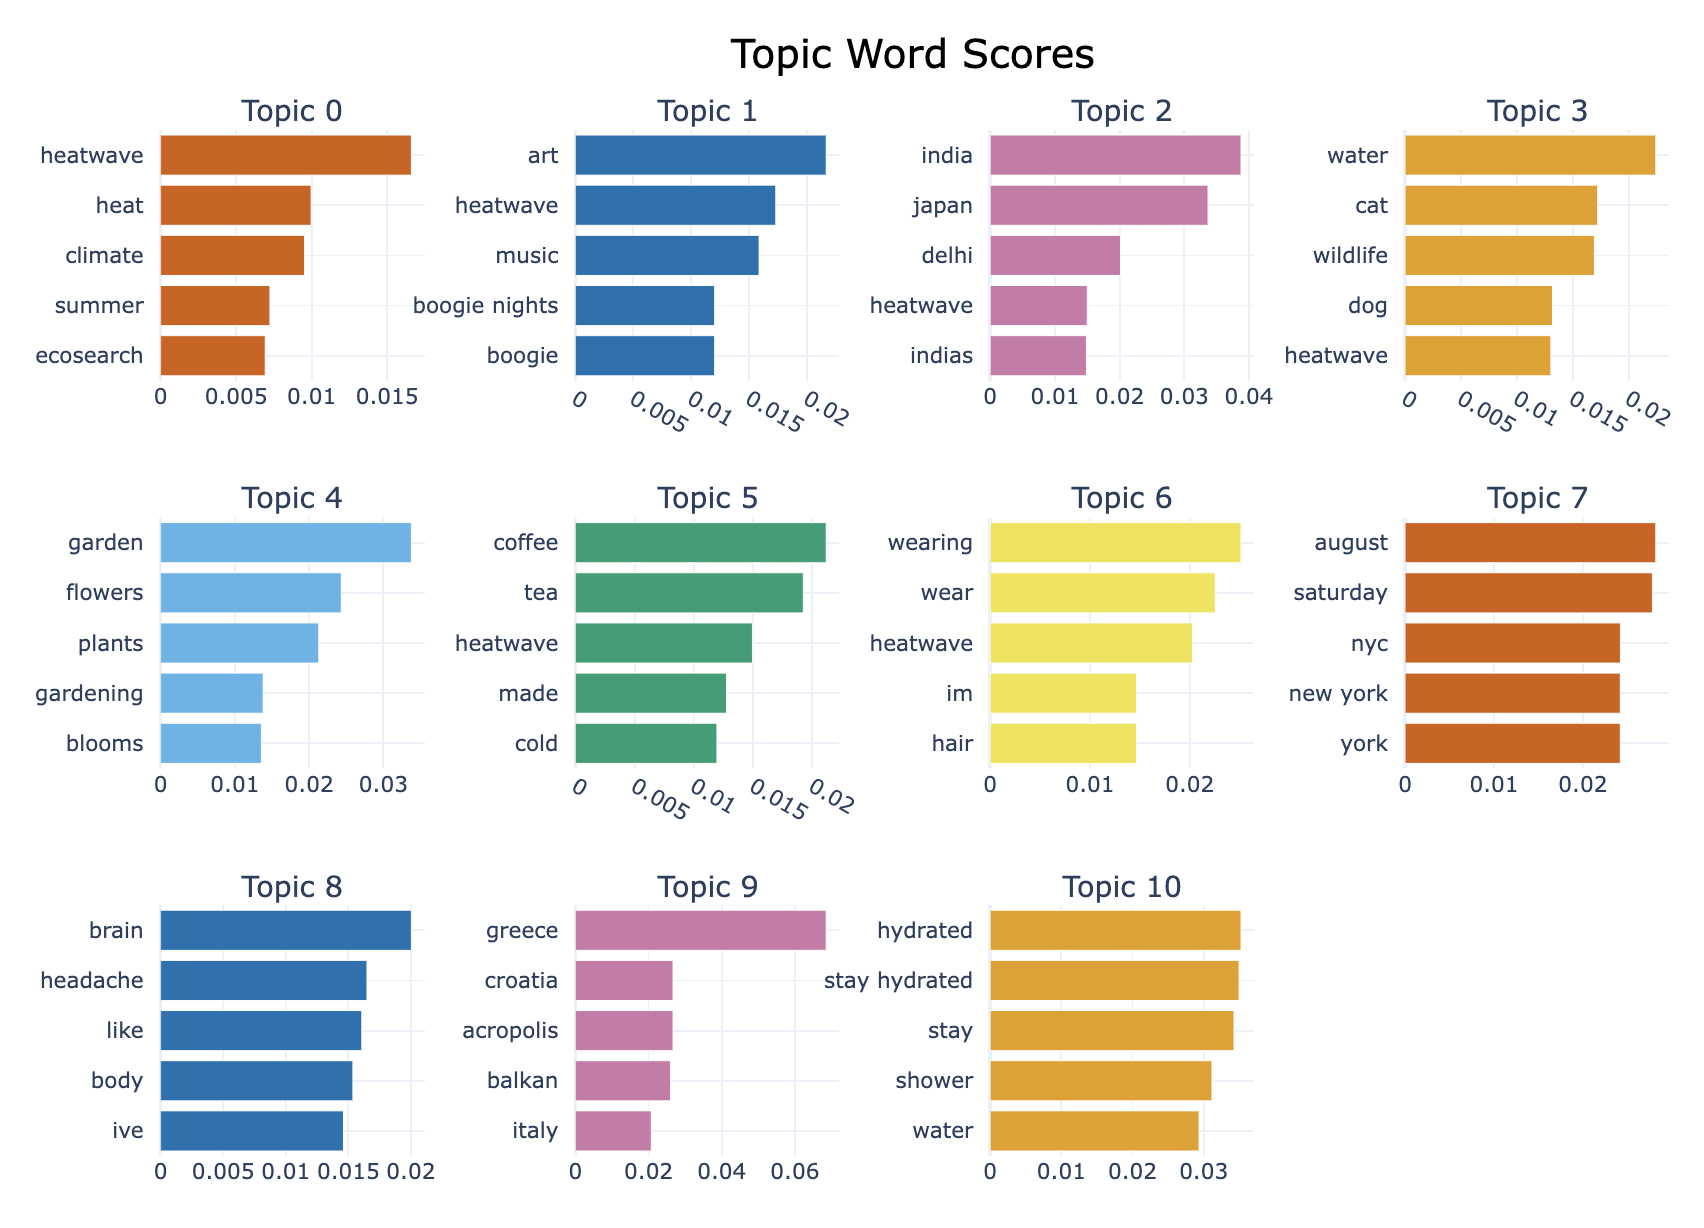